In [30]:
!nvidia-smi

Tue Nov 24 15:56:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp '/content/drive/My Drive/GIZ Zindi/Train.csv' .
!cp '/content/drive/My Drive/GIZ Zindi/SampleSubmission.csv' .

In [4]:
!cp '/content/drive/My Drive/GIZ Zindi/AdditionalUtterances.zip' AdditionalUtterances.zip

In [5]:
!unzip -q AdditionalUtterances.zip

In [6]:
# Copy the files in and unzip
!cp '/content/drive/My Drive/GIZ Zindi/audio_files.zip' audio_files.zip
!unzip -q audio_files.zip

In [7]:
!cp "/content/drive/My Drive/GIZ Zindi/nlp_keywords_29Oct2020.zip" nlp_keywords_29Oct2020.zip
!unzip -q nlp_keywords_29Oct2020.zip

In [8]:
!pip -q install efficientnet_pytorch

In [9]:
!pip install -q python_speech_features

In [10]:
!pip -q install albumentations --upgrade

     |████████████████████████████████| 81kB 7.0MB/s 
     |████████████████████████████████| 36.7MB 88kB/s 
     |████████████████████████████████| 952kB 60.6MB/s 


In [11]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch
import torchvision.models as models
from efficientnet_pytorch import EfficientNet
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import OneCycleLR
import pandas as pd 
import numpy as np
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm.notebook import tqdm as tqdm 
from sklearn.model_selection import train_test_split
import librosa
import librosa.display as display
import python_speech_features as psf
from matplotlib import pyplot as plt
import numpy as np
import albumentations
from torch.nn import Module,Sequential
import gc
import cv2
import multiprocessing as mp 
from multiprocessing import Pool
from albumentations.augmentations.transforms import Lambda
import IPython.display as ipd 

In [12]:
N_WORKERS = mp.cpu_count()
LOAD_TRAIN_DATA = None
LOAD_TEST_DATA = None

In [13]:
import random
import numpy as np
SEED_VAL  = 1000
# Set the seed value all over the place to make this reproducible.
def seed_all(SEED = SEED_VAL):
  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed_all(SEED)
  os.environ['PYTHONHASHSEED'] = str(SEED)
  torch.backends.cudnn.deterministic = True

## New atterances

In [14]:
def create_new_train():  
  import glob
  dirs = glob.glob('latest_keywords/*')
  #firts wave 
  new_atterances = pd.DataFrame()
  labels = []
  fn = []
  for dir in dirs:
    wav_paths = glob.glob(dir+'/*')
    fn.extend(wav_paths)
    labels.extend(len(wav_paths) * [dir.split('/')[-1]])
  new_atterances['fn'] = fn
  new_atterances['label'] = labels
  new_atterances = new_atterances.sample(frac=1,random_state=SEED_VAL).reset_index(drop=True)

  #second wave
  dirs = glob.glob('nlp_keywords/*')
  new_atterances1 = pd.DataFrame()
  labels = []
  fn = []
  for dir in dirs:
    wav_paths = glob.glob(dir+'/*')
    fn.extend(wav_paths)
    labels.extend(len(wav_paths) * [dir.split('/')[-1]])
  new_atterances1['fn'] = fn
  new_atterances1['label'] = labels
  new_atterances1 = new_atterances1.sample(frac=1,random_state=SEED_VAL).reset_index(drop=True) 

  #combine all 
  train = pd.read_csv('Train.csv')
  train = pd.concat([train,new_atterances,new_atterances1])
  train = train.sample(frac=1,random_state=SEED_VAL).reset_index(drop=True)
  train.to_csv('new_train.csv',index=False)
  print(train.head())
  print(train.shape)
create_new_train()

                                                  fn         label
0  latest_keywords/ebbugga/2497942026ef4d7e97d47f...       ebbugga
1                            audio_files/MQKXCIO.wav   ebijanjaalo
2  latest_keywords/ensiringanyi/d45cd9903b3044d49...  ensiringanyi
3  latest_keywords/abalimi/1b5a69c4b88b41eb9577a6...       abalimi
4  nlp_keywords/ekitooke/d027264654b94950aeb204f6...      ekitooke
(4709, 2)


# DataLoader

In [15]:
class conf:
    sampling_rate = 44100
    duration = 3 # sec
    hop_length = 200*duration # to make time steps 128
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    padmode = 'constant'
    samples = sampling_rate * duration
def get_default_conf():
    return conf

conf = get_default_conf()

In [16]:
def melspectogram_dB(file_path, cst=3, top_db=80.):
  row_sound, sr = librosa.load(file_path,sr=conf.sampling_rate)
  sound = np.zeros((cst*sr,))
  if row_sound.shape[0] < cst*sr:
    sound[:row_sound.shape[0]] = row_sound[:]
  else:
    sound[:] = row_sound[:cst*sr]

  spec = librosa.feature.melspectrogram(sound, 
                                    sr=conf.sampling_rate,
                                    n_mels=conf.n_mels,
                                    hop_length=conf.hop_length,
                                    n_fft=conf.n_fft,
                                    fmin=conf.fmin,
                                    fmax=conf.fmax)
  spec_db = librosa.power_to_db(spec)
  spec_db = spec_db.astype(np.float32)

  return spec_db

def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_img = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  
  return spec_img.astype(np.uint8)
def preprocess_audio(audio_path):
  spec = melspectogram_dB(audio_path)
  spec = spec_to_image(spec)
  return spec

(128, 221)


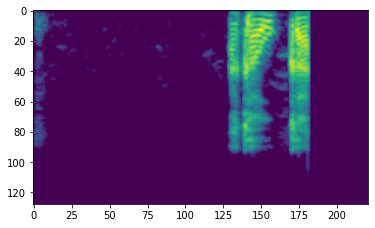

In [17]:
spec = preprocess_audio('/content/audio_files/IV38R7F.wav')
print(spec.shape)
plt.imshow(spec)

(128, 221)


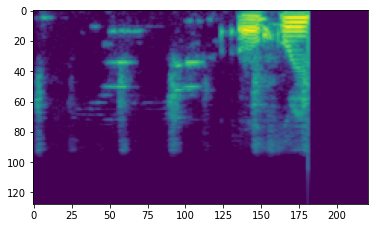

In [18]:
spec = preprocess_audio('audio_files/B6NYZM0.wav')
print(spec.shape)
plt.imshow(spec)

In [19]:
def get_data(df,mode='train'):
  """
  :param: df: dataframe of train or test
  :return: images_list: spec images of all the data
  :return: label_list : label list of all the data
  """
  audio_paths = df.fn.values
  images_list = []
  with mp.Pool(N_WORKERS) as pool:
    images_list = pool.map(preprocess_audio,tqdm(audio_paths))

  if mode == 'train':
    label_list = df.label.values
    return images_list,label_list
  else:
    return images_list

In [20]:
class ImageDataset(Dataset):
    def __init__(self, images_list,labels_list=None,transform=None):
        self.images_list = images_list
        self.transform = transform
        self.labels_list = labels_list

    def __getitem__(self, index):
      
      spec = self.images_list[index]
      if self.transform is not None:
        spec = self.transform(image=spec)
        spec = spec['image']
        
      if self.labels_list is not None:
          label = self.labels_list[index]
          return {'image' : torch.tensor(spec,dtype=torch.float), 
              'label' : torch.tensor(label,dtype = torch.long) }
          
      return {'image' : torch.tensor(spec,dtype=torch.float), }

    def __len__(self):
        return len(self.images_list)

# Models and train functions

In [21]:
class Net(nn.Module):
    def __init__(self,name):
        super(Net, self).__init__()
        self.name  = name
        #self.convert_3_channels = nn.Conv2d(1,3,2,padding=1)
        if name == 'b0':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b0')
          self.arch._fc = nn.Linear(in_features=1280, out_features=193, bias=True)
        elif name == 'b1':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b1')
          self.arch._fc = nn.Linear(in_features=1280, out_features=193, bias=True)
        elif name == 'b2':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b2')
          self.arch._fc = nn.Linear(in_features=1408, out_features=193, bias=True)
        elif name =='b3':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b3')
          self.arch._fc = nn.Linear(in_features=1536, out_features=193, bias=True)
        elif name =='b4':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b4')
          self.arch._fc = nn.Linear(in_features=1792, out_features=193, bias=True,)
        elif name =='b5':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b5')
          self.arch._fc = nn.Linear(in_features=2048, out_features=193, bias=True)
        elif name =='b6':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b6')
          self.arch._fc = nn.Linear(in_features=2304, out_features=193, bias=True)
        elif name =='b7':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b7')
          self.arch._fc = nn.Linear(in_features=2560, out_features=193, bias=True)
        elif name == 'densenet121':
          self.arch = models.densenet121(pretrained=True)
          num_ftrs = self.arch.classifier.in_features
          self.arch.classifier = nn.Linear(num_ftrs,193,bias=True)
        elif name == 'densenet169':
          self.arch = models.densenet169(pretrained=True)
          num_ftrs = self.arch.classifier.in_features
          self.arch.classifier = nn.Linear(num_ftrs,193,bias=True)
        elif name == 'densenet201':
          self.arch = models.densenet201(pretrained=True)
          num_ftrs = self.arch.classifier.in_features
          self.arch.classifier = nn.Linear(num_ftrs,193,bias=True)
        elif name == 'resnet50':
          self.arch = models.resnet50(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,193,bias=True)
        elif name == 'resnet101':
          self.arch = models.resnet101(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,193,bias=True)
        elif name == 'resnet152':
          self.arch = models.resnet152(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,193,bias=True)
        elif name == 'resnet18':
          self.arch = models.resnet18(pretrained=True)
          my_weight = self.arch.conv1.weight.mean(dim=1, keepdim=True)    
          self.arch.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          self.arch.conv1.weight = torch.nn.Parameter(my_weight)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,193,bias=True)
        elif name == 'resnet34':
          self.arch = models.resnet34(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,193,bias=True)
        elif name == 'resnext101':
          self.arch = models.resnext101_32x8d(pretrained=True)
          my_weight = self.arch.conv1.weight.mean(dim=1, keepdim=True)    
          self.arch.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          self.arch.conv1.weight = torch.nn.Parameter(my_weight)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,193,bias=True)
        elif name == 'resnext50':
          self.arch = models.resnext50_32x4d(pretrained=True)
          my_weight = self.arch.conv1.weight.mean(dim=1, keepdim=True)    
          self.arch.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          self.arch.conv1.weight = torch.nn.Parameter(my_weight)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,193,bias=True)
        elif name =='rexnetv1':
            model = rexnetv1.ReXNetV1(width_mult=1.0)
            model.output.conv2D = nn.Conv2d(1280, 1, kernel_size=(1, 1), stride=(1, 1))
          
    def forward(self, x):
        """
        """
        #x = self.convert_3_channels(x)
        x = self.arch(x)
        return x

In [22]:
class AverageMeter():
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [23]:
def loss_fn(outputs,targets):
  criterion =  nn.CrossEntropyLoss()
  return criterion(outputs,targets)

In [24]:
def train_fn(train_data_loader,model,optimizer,device,scheduler = None):
  model.train()
  tot_loss = 0
  for bi,d in enumerate(train_data_loader):
    images = d['image']
    labels = d['label']

    #send them to device 
    images = images.to(device,dtype=torch.float)
    labels = labels.to(device,dtype=torch.long)
    optimizer.zero_grad()
    
    outputs  = model(images.unsqueeze(dim=1))
    loss = loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()
    tot_loss = tot_loss + loss.item()
  if scheduler is not None:
    scheduler.step()
  logloss_score = tot_loss/len(train_data_loader) 

In [25]:
def eval_fn(valid_data_loader,model,device):
  model.eval()
  tot_loss = 0
  with torch.no_grad():
    for bi,d in enumerate(valid_data_loader):
      images = d['image']
      labels = d['label']
      #send them to device 
      images = images.to(device,dtype=torch.float)
      labels = labels.to(device,dtype=torch.long)  
      outputs  = model(images.unsqueeze(dim=1))
      loss = loss_fn(outputs,labels)
      tot_loss = tot_loss + loss.item()
    logloss_score  = tot_loss/len(valid_data_loader)
    return logloss_score


# Training

In [28]:
#Takes 8 minutes
%%time
if LOAD_TRAIN_DATA is None:
  gc.collect()
  train = pd.read_csv('new_train.csv')
  ss = pd.read_csv('/content/SampleSubmission.csv')
  cols = ss.columns[1:].values
  dict_cols  = {}
  for i, col in enumerate(cols):
    dict_cols[col] = i
  dict_cols
  train.label = train.label.map(dict_cols)
  print(train.head())
  train_images,train_labels = get_data(train,mode='train')
  LOAD_TRAIN_DATA = True
else:
  print('Data Already Loaded')

                                                  fn  label
0  latest_keywords/ebbugga/2497942026ef4d7e97d47f...     35
1                            audio_files/MQKXCIO.wav    131
2  latest_keywords/ensiringanyi/d45cd9903b3044d49...     58
3  latest_keywords/abalimi/1b5a69c4b88b41eb9577a6...     96
4  nlp_keywords/ekitooke/d027264654b94950aeb204f6...    161



CPU times: user 800 ms, sys: 340 ms, total: 1.14 s
Wall time: 17min 9s


In [29]:
HEIGHT = 128
WIDTH = 600
def get_transforms(): 
  train_transform = albumentations.Compose([
      #albumentations.PadIfNeeded(HEIGHT,WIDTH,border_mode = cv2.BORDER_CONSTANT,value=0),
      albumentations.Resize(HEIGHT,WIDTH),
      #albumentations.Lambda(NM(),always_apply=True)
      #Lambda(image=SpecAugment(num_mask=2,freq_masking=0.1,time_masking=0.1),mask=None,p=0.2),
      #Lambda(image=GaussNoise(2),mask=None,p=0.2),
      #albumentations.Lambda(image=CONVERTRGB(),always_apply=True),
      #albumentations.CenterCrop(100,140,p=1)
      #albumentations.RandomCrop(120,120)
      #albumentations.VerticalFlip(p=0.2),
      #albumentations.HorizontalFlip(p=0.2),
      #albumentations.RandomContrast(p=0.2),
      
      #AT.ToTensor()
      ])
  val_transform = albumentations.Compose([
      #albumentations.PadIfNeeded(HEIGHT,WIDTH,border_mode = cv2.BORDER_CONSTANT,value=0),
      albumentations.Resize(HEIGHT,WIDTH),
      #albumentations.Lambda(NM(),always_apply=True)
      #albumentations.Lambda(image=CONVERTRGB(),always_apply=True),
      #AT.ToTensor()
      ])
  return train_transform,val_transform

## KFOLDS

In [31]:
NAME = 'resnext101'
EPOCHS = 15
TRAIN_BATCH_SIZE = 8
LR = 0.0001
NFOLDS = 10

In [32]:
skf = StratifiedKFold(NFOLDS,random_state=SEED_VAL,shuffle=True)
all_scores = []
def run_folds(train_images,train_labels):
  seed_all(SEED_VAL)
  train_transform,val_transform = get_transforms()
  for i,(train_index,val_index) in enumerate(skf.split(train_labels,y=train_labels)):
    if i in [0,1]:
      print(f"#########################  Fold {i+1}/{skf.n_splits}  #########################")
      tr_images,valid_images = [train_images[i] for i in train_index] ,[train_images[i] for i in val_index]
      tr_labels,valid_labels = [train_labels[i] for i in train_index],[train_labels[i] for i in val_index]
      
      train_dataset = ImageDataset(tr_images,tr_labels,transform=train_transform)
      valid_dataset = ImageDataset(valid_images,valid_labels,transform = val_transform)
      train_data_loader = DataLoader(dataset=train_dataset,shuffle=True,batch_size=TRAIN_BATCH_SIZE)
      valid_data_loader = DataLoader(dataset=valid_dataset,shuffle=False,batch_size=32)
    
      device = torch.device("cuda")
      model = Net(NAME)
      model.to(device)

      
      optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
      scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, factor=0.7,min_lr=1e-6,verbose=True)    

      best_log_loss = 1500
      for epoch in range(EPOCHS):
        print(f"----------------FOLD {i+1} : EPOCH {epoch+1}---------------------")
        train_fn(train_data_loader, model, optimizer, device,scheduler=None)
        log_loss_val = eval_fn(valid_data_loader ,model, device)
        scheduler.step(log_loss_val)
        print("val loss: ",log_loss_val)
        if log_loss_val<best_log_loss:
          best_log_loss = log_loss_val 
          torch.save(model.state_dict(),f"best_model_{i}")
          #torch.save(model.state_dict(),f"/content/drive/MyDrive/Resnext101GIZ/best_model_{i}")
          
      all_scores.append(best_log_loss) 
      print(f'best VAL_LOGLOSS for fold {i+1}: ',best_log_loss)
    else:
      pass
  print(f"MEAN over all FOLDS: {np.mean(all_scores)}")
  return np.mean(all_scores)

CV_SCORE = run_folds(train_images,train_labels)